# Gradient Boosting Model

## Introduction

We can start by loading the packages.



In [1]:
require(devtools)
Sys.unsetenv("GITHUB_PAT")
install_github("gbm-developers/gbm3")

library(gbm3)
library(caret)
library(mgcv)
library(reshape2)
library(ggplot2)
library(dplyr)
library(arrow)

Le chargement a nécessité le package : devtools

Le chargement a nécessité le package : usethis

Skipping install of 'gbm3' from a github remote, the SHA1 (55919f4b) has not changed since last install.
  Use `force = TRUE` to force installation

Le chargement a nécessité le package : ggplot2

Le chargement a nécessité le package : lattice

Le chargement a nécessité le package : nlme

This is mgcv 1.8-42. For overview type 'help("mgcv-package")'.


Attachement du package : 'dplyr'


L'objet suivant est masqué depuis 'package:nlme':

    collapse


Les objets suivants sont masqués depuis 'package:stats':

    filter, lag


Les objets suivants sont masqués depuis 'package:base':

    intersect, setdiff, setequal, union



Attachement du package : 'arrow'


L'objet suivant est masqué depuis 'package:utils':

    timestamp




We can also load the data (same as in the previous sessions).

In [2]:
dataset = read_parquet(file = "../data/dataset.parquet")

set.seed(21)
in_training = createDataPartition(dataset$ClaimNb, times = 1, p = 0.8, list = FALSE)
training_set = dataset[in_training, ]
testing_set = dataset[-in_training, ]

## R Package GBM3

The gbm3 package is very similar to the package gbm available on CRAN. However, the gbm package is now an orphan, while the gbm3 package is basically an enhanced version of the gbm package and is maintained.

In [3]:
available_distributions()

[1] "AdaBoost"  "Bernoulli" "CoxPH"     "Gamma"     "Gaussian"  "Huberized"
 [7] "Laplace"   "Pairwise"  "Poisson"   "Quantile"  "TDist"     "Tweedie"

### Small Example with two variables.

The main function is gbmt.

In [4]:
set.seed(1)
m0 = gbmt(ClaimNb ~ offset(log(Exposure)) + CarAge + DriverAge,
         data = training_set,
         distribution = gbm_dist("Poisson"),
         train_params = training_params(num_trees = 100,
                                        shrinkage = 0.01, #Default is 0.001
                                        interaction_depth = 5,  #the max number of non-terminal nodes in each tree 
                                        min_num_obs_in_node = 1000,
                                        bag_fraction = 0.5, # At each tree, only 50% of the data is considered
                                        num_train = 1*nrow(training_set)), #100% of the training set will be used in the learning process
         is_verbose = TRUE,
         keep_gbm_data = TRUE,
         par_details = gbmParallel(num_threads = 3)) #Parallel computing

Fitting Final Model 




Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.3298             nan     0.0100    0.0000
     2        0.3297             nan     0.0100    0.0000
     3        0.3297             nan     0.0100    0.0000
     4        0.3297             nan     0.0100    0.0000
     5        0.3296             nan     0.0100    0.0000
     6        0.3296             nan     0.0100    0.0000
     7        0.3296             nan     0.0100    0.0000
     8        0.3295             nan     0.0100    0.0000
     9        0.3295             nan     0.0100    0.0000
    10        0.3294             nan     0.0100    0.0000
    20        0.3291             nan     0.0100    0.0000
    40        0.3286             nan     0.0100    0.0000
    60        0.3283             nan     0.0100    0.0000
    80        0.3280             nan     0.0100    0.0000
   100        0.3278             nan     0.0100    0.0000



We can find the optimal number of trees using gbmt_performance. In this case, since no validation set has been provided, it will be based on out-of-bag samples. Does this make sense ? What is an OOB in the case of a GBM ?

In [7]:
gbmt_performance(m0, method = "OOB")

OOB generally underestimates the optimal number of iterations although predictive performance is reasonably competitive.
            Using cv_folds>1 when calling gbm usually results in improved predictive performance.



The best out-of-bag iteration was 100.

Sometimes the GBM won’t have enough trees. This can be seen when the optimal number of trees equals to total number of trees. No need to rerun everything, we can just add some new trees.

In [8]:
set.seed(2)
m1 = gbm_more(m0, num_new_trees = 400, is_verbose = TRUE)

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
   101        0.3277             nan     0.0100    0.0000
   102        0.3277             nan     0.0100    0.0000
   103        0.3277             nan     0.0100    0.0000
   104        0.3277             nan     0.0100    0.0000
   105        0.3277             nan     0.0100    0.0000
   106        0.3277             nan     0.0100    0.0000
   107        0.3277             nan     0.0100    0.0000
   108        0.3277             nan     0.0100    0.0000
   109        0.3277             nan     0.0100    0.0000
   110        0.3276             nan     0.0100    0.0000
   120        0.3276             nan     0.0100    0.0000
   140        0.3274             nan     0.0100    0.0000
   160        0.3273             nan     0.0100    0.0000
   180        0.3272             nan     0.0100    0.0000
   200        0.3271             nan     0.0100    0.0000
   220        0.3271             nan     0.0100    0.0000
   240        

We can check the optimal number of trees based on the out-of-bag observations.

In [9]:
gbmt_performance(m1, method="OOB")

OOB generally underestimates the optimal number of iterations although predictive performance is reasonably competitive.
            Using cv_folds>1 when calling gbm usually results in improved predictive performance.



The best out-of-bag iteration was 293.

**However, since OOB does not make much sense for GBM (due to the sequential nature of the algorithm), one should rather rely on cross-validation to find the optimal number of boosting iterations.**

In [10]:
set.seed(1)
m0 = gbmt(ClaimNb ~ offset(log(Exposure)) + CarAge + DriverAge,
         data = training_set,
         distribution = gbm_dist("Poisson"),
         train_params = training_params(num_trees = 400,
                                        shrinkage = 0.01, # Default is 0.001
                                        interaction_depth = 5,  #the max number of non-terminal nodes in each tree 
                                        min_num_obs_in_node = 1000,
                                        bag_fraction = 0.5,
                                        num_train = 1*nrow(training_set)),
         is_verbose = TRUE,
         keep_gbm_data = TRUE,
         cv_folds = 5,
         par_details = gbmParallel(num_threads = 3)) #Parallel computing, depends on your CPU

Fitting Final Model 




Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.3298             nan     0.0100    0.0000
     2        0.3297             nan     0.0100    0.0000
     3        0.3297             nan     0.0100    0.0000
     4        0.3297             nan     0.0100    0.0000
     5        0.3296             nan     0.0100    0.0000
     6        0.3296             nan     0.0100    0.0000
     7        0.3296             nan     0.0100    0.0000
     8        0.3295             nan     0.0100    0.0000
     9        0.3295             nan     0.0100    0.0000
    10        0.3294             nan     0.0100    0.0000
    20        0.3291             nan     0.0100    0.0000
    40        0.3286             nan     0.0100    0.0000
    60        0.3283             nan     0.0100    0.0000
    80        0.3280             nan     0.0100    0.0000
   100        0.3278             nan     0.0100    0.0000
   120        0.3275             nan     0.0100    0.0000
   140        

CV:1




Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.3309          0.3256     0.0100    0.0000
     2        0.3308          0.3255     0.0100    0.0000
     3        0.3308          0.3255     0.0100    0.0000
     4        0.3307          0.3255     0.0100    0.0000
     5        0.3307          0.3254     0.0100    0.0000
     6        0.3307          0.3254     0.0100    0.0000
     7        0.3306          0.3253     0.0100    0.0000
     8        0.3306          0.3253     0.0100    0.0000
     9        0.3306          0.3253     0.0100    0.0000
    10        0.3305          0.3252     0.0100    0.0000
    20        0.3302          0.3249     0.0100    0.0000
    40        0.3297          0.3243     0.0100    0.0000
    60        0.3293          0.3239     0.0100    0.0000
    80        0.3290          0.3236     0.0100    0.0000
   100        0.3287          0.3233     0.0100    0.0000
   120        0.3286          0.3232     0.0100    0.0000
   140        

CV:2




Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.3294          0.3313     0.0100    0.0000
     2        0.3293          0.3313     0.0100    0.0000
     3        0.3293          0.3313     0.0100    0.0000
     4        0.3293          0.3312     0.0100    0.0000
     5        0.3292          0.3312     0.0100    0.0000
     6        0.3292          0.3312     0.0100    0.0000
     7        0.3292          0.3311     0.0100    0.0000
     8        0.3292          0.3311     0.0100    0.0000
     9        0.3291          0.3311     0.0100    0.0000
    10        0.3291          0.3311     0.0100    0.0000
    20        0.3289          0.3309     0.0100    0.0000
    40        0.3283          0.3303     0.0100    0.0000
    60        0.3278          0.3300     0.0100    0.0000
    80        0.3275          0.3297     0.0100    0.0000
   100        0.3273          0.3295     0.0100    0.0000
   120        0.3271          0.3294     0.0100    0.0000
   140        

CV:3




Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.3297          0.3302     0.0100    0.0000
     2        0.3296          0.3302     0.0100    0.0000
     3        0.3296          0.3301     0.0100    0.0000
     4        0.3296          0.3301     0.0100    0.0000
     5        0.3295          0.3300     0.0100    0.0000
     6        0.3295          0.3300     0.0100    0.0000
     7        0.3294          0.3299     0.0100    0.0000
     8        0.3294          0.3299     0.0100    0.0000
     9        0.3294          0.3299     0.0100    0.0000
    10        0.3293          0.3298     0.0100    0.0000
    20        0.3290          0.3295     0.0100    0.0000
    40        0.3284          0.3290     0.0100    0.0000
    60        0.3280          0.3286     0.0100    0.0000
    80        0.3278          0.3283     0.0100    0.0000
   100        0.3275          0.3281     0.0100    0.0000
   120        0.3274          0.3279     0.0100    0.0000
   140        

CV:4




Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.3293          0.3317     0.0100    0.0000
     2        0.3293          0.3317     0.0100    0.0000
     3        0.3292          0.3316     0.0100    0.0000
     4        0.3292          0.3316     0.0100    0.0000
     5        0.3292          0.3316     0.0100    0.0000
     6        0.3291          0.3315     0.0100    0.0000
     7        0.3291          0.3315     0.0100    0.0000
     8        0.3290          0.3315     0.0100    0.0000
     9        0.3290          0.3314     0.0100    0.0000
    10        0.3290          0.3314     0.0100    0.0000
    20        0.3286          0.3311     0.0100    0.0000
    40        0.3281          0.3305     0.0100    0.0000
    60        0.3277          0.3302     0.0100    0.0000
    80        0.3274          0.3299     0.0100    0.0000
   100        0.3272          0.3297     0.0100    0.0000
   120        0.3270          0.3295     0.0100    0.0000
   140        

CV:5




Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.3297          0.3301     0.0100    0.0000
     2        0.3296          0.3301     0.0100    0.0000
     3        0.3296          0.3300     0.0100    0.0000
     4        0.3296          0.3300     0.0100    0.0000
     5        0.3295          0.3300     0.0100    0.0000
     6        0.3295          0.3299     0.0100    0.0000
     7        0.3295          0.3299     0.0100    0.0000
     8        0.3294          0.3299     0.0100    0.0000
     9        0.3294          0.3298     0.0100    0.0000
    10        0.3294          0.3298     0.0100    0.0000
    20        0.3291          0.3296     0.0100    0.0000
    40        0.3285          0.3291     0.0100    0.0000
    60        0.3281          0.3287     0.0100    0.0000
    80        0.3278          0.3285     0.0100    0.0000
   100        0.3275          0.3283     0.0100    0.0000
   120        0.3273          0.3281     0.0100    0.0000
   140        

Here, with cv, unfortunately, we cannot add more trees. We can plot the deviance as a function of the number of trees: a "maximalist" approach should be preferred. We can still prune the GBM, but not add extra boosting steps.



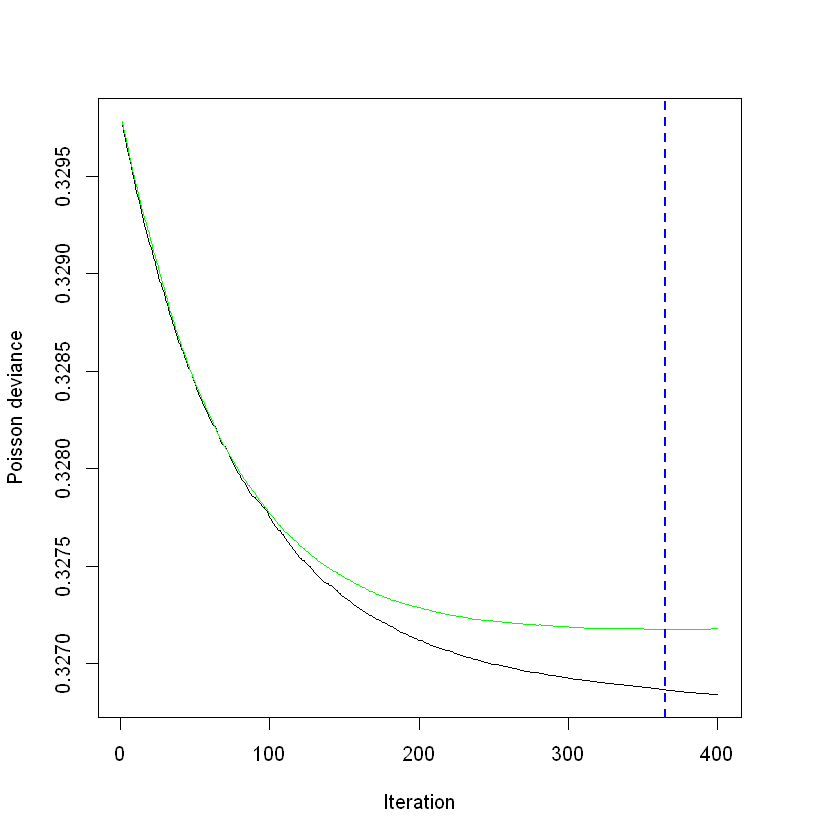

In [11]:
plot(gbmt_performance(m0, method = "cv"))

To get the numerical value,

In [12]:
best_iter = gbmt_performance(m0, method = "cv")
best_iter

The best cross-validation iteration was 365.

The cross-validation error for the optimal iteration can be retrieved.

In [13]:
m0$cv_error[gbmt_performance(m0, method="cv")]

[1] 0.3271756

We also have a variable importance metric. For GBMs, importance depends on whether that variable was selected to split on during the tree building process, and how much the loss function (over all trees) improved (decreased) as a result.

,var,rel_inf
,<chr>,<dbl>
DriverAge,DriverAge,85.29163
CarAge,CarAge,14.70837


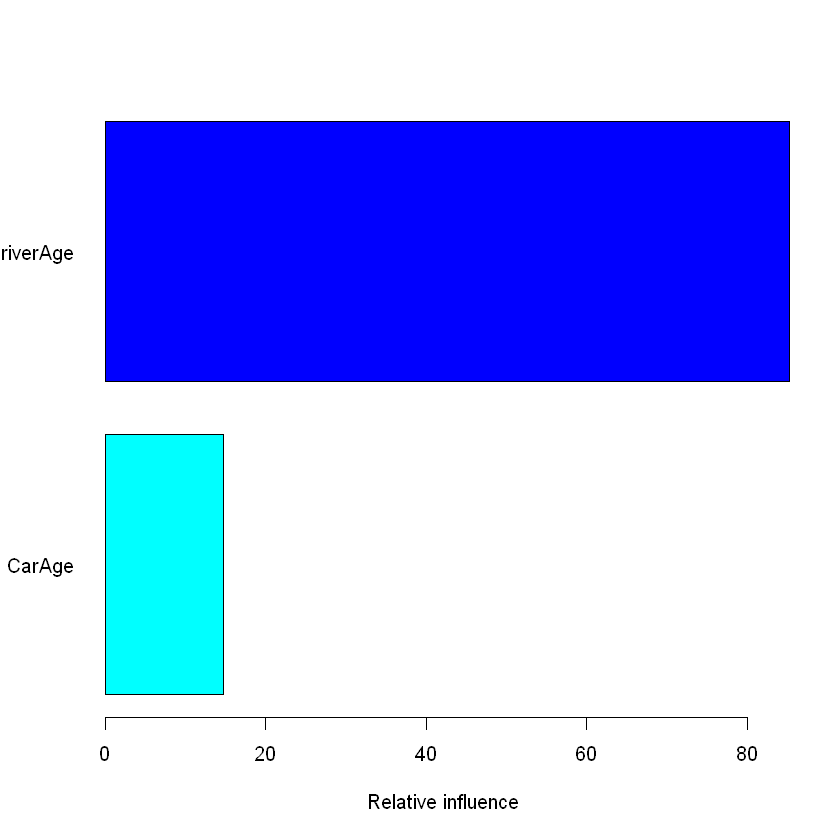

In [14]:
summary(m0, num_trees = best_iter)

We can plot the partial dependencies of the variables.


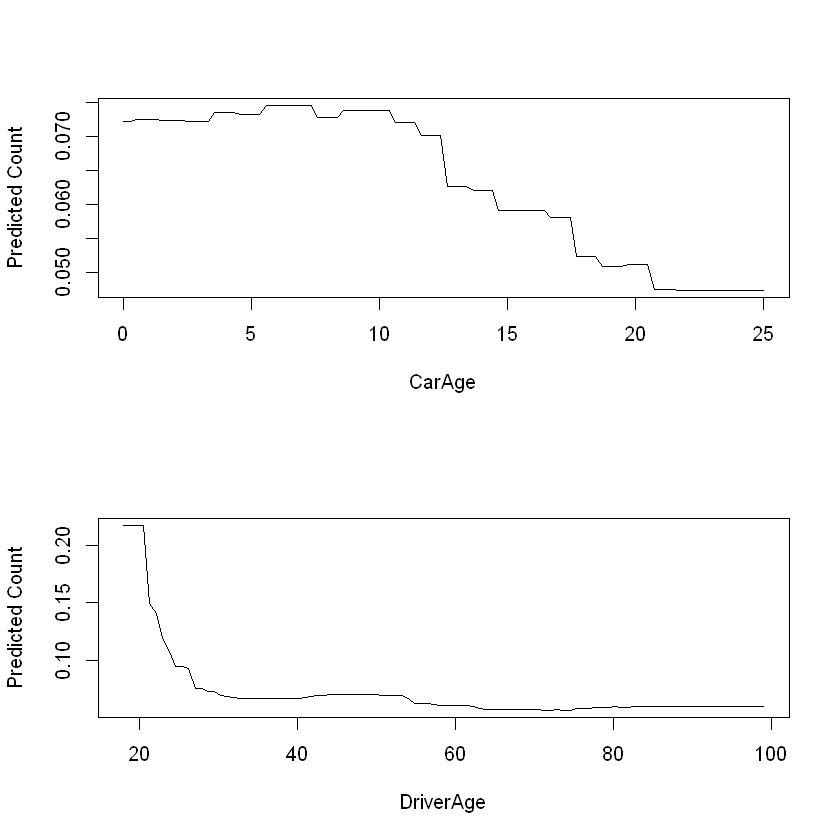

In [15]:
par(mfrow = c(2, 1))
plot(m0, var_index = 1, num_trees = best_iter, type = "response")
plot(m0, var_index = 2, num_trees = best_iter, type = "response")

When we are finished, we can evaluate the performance of the model on the testing set.

In [16]:
2 * (sum(dpois(x = testing_set$ClaimNb, lambda = testing_set$ClaimNb, log = TRUE)) -
    sum(dpois(x = testing_set$ClaimNb, lambda = predict(m0, 
                                                        newdata = testing_set,
                                                        n.trees = best_iter, 
                                                        type = "response") * testing_set$Exposure, log = TRUE)))

Warning message in predict.GBMFit(m0, newdata = testing_set, n.trees = best_iter, :
"predict.GBMFit does not add the offset to the predicted values."


[1] 20592.45

We can take a look at the first tree, using the pretty_gbm_tree function.

In [17]:
pretty_gbm_tree(m0, tree_index =1) %>% 
  filter(SplitVar != -1) # Only keep non terminal nodes

SplitVar,SplitCodePred,LeftNode,RightNode,MissingNode,ErrorReduction,Weight,Prediction
<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,26.5,1,5,15,10.3689908,164346,-0.16169634
1,21.5,2,3,4,2.5599754,13077,-0.09202991
1,54.5,6,13,14,1.6810709,151269,-0.13696844
1,43.5,7,8,12,0.4837179,110602,-0.11400078
0,15.5,9,10,11,0.8530792,43680,-0.09487140


### Using all variables

Let’s now perform the cross-validation with 1000 trees. (~ 6 minutes). We will only perform this CV for one set of hyperparameters (due to time constraint). Obviously, the idea would be to *loop* on different values for these hyperparameters, and select those that yield the loss error as estimated by cross-validation.


In [18]:
set.seed(89)
m0_gbm = gbmt(ClaimNb ~ offset(log(Exposure)) + CarAge + DriverAge + Power + Brand + Gas + Region + Density,
         data = training_set,
         distribution = gbm_dist("Poisson"),
         train_params = training_params(num_trees = 1000,
                                        shrinkage = 0.01, #Default is 0.001
                                        interaction_depth = 5,  #the max number of non - terminal nodes in each tree 
                                        min_num_obs_in_node = 1000,
                                        bag_fraction = 0.5,
                                        num_train = 1*nrow(training_set)),
         is_verbose = TRUE,
         cv_folds = 5,
         keep_gbm_data = TRUE,
         par_details = gbmParallel(num_threads = 3)) #Parallel computing

Fitting Final Model 




Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.3298             nan     0.0100    0.0000
     2        0.3298             nan     0.0100    0.0000
     3        0.3297             nan     0.0100    0.0000
     4        0.3297             nan     0.0100    0.0000
     5        0.3297             nan     0.0100    0.0000
     6        0.3297             nan     0.0100    0.0000
     7        0.3296             nan     0.0100    0.0000
     8        0.3296             nan     0.0100    0.0000
     9        0.3295             nan     0.0100    0.0000
    10        0.3295             nan     0.0100    0.0000
    20        0.3292             nan     0.0100    0.0000
    40        0.3287             nan     0.0100    0.0000
    60        0.3282             nan     0.0100    0.0000
    80        0.3278             nan     0.0100    0.0000
   100        0.3275             nan     0.0100    0.0000
   120        0.3272             nan     0.0100    0.0000
   140        

CV:1




Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.3308          0.3257     0.0100    0.0000
     2        0.3308          0.3257     0.0100    0.0000
     3        0.3308          0.3257     0.0100    0.0000
     4        0.3307          0.3257     0.0100    0.0000
     5        0.3307          0.3256     0.0100    0.0000
     6        0.3306          0.3256     0.0100    0.0000
     7        0.3306          0.3255     0.0100    0.0000
     8        0.3306          0.3255     0.0100    0.0000
     9        0.3305          0.3255     0.0100    0.0000
    10        0.3305          0.3255     0.0100    0.0000
    20        0.3303          0.3253     0.0100    0.0000
    40        0.3297          0.3247     0.0100    0.0000
    60        0.3293          0.3243     0.0100    0.0000
    80        0.3289          0.3239     0.0100    0.0000
   100        0.3285          0.3235     0.0100    0.0000
   120        0.3282          0.3232     0.0100    0.0000
   140        

CV:2




Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.3294          0.3314     0.0100    0.0000
     2        0.3294          0.3314     0.0100    0.0000
     3        0.3293          0.3314     0.0100    0.0000
     4        0.3293          0.3313     0.0100    0.0000
     5        0.3292          0.3313     0.0100    0.0000
     6        0.3292          0.3313     0.0100    0.0000
     7        0.3292          0.3312     0.0100    0.0000
     8        0.3292          0.3312     0.0100    0.0000
     9        0.3291          0.3312     0.0100    0.0000
    10        0.3291          0.3312     0.0100    0.0000
    20        0.3288          0.3309     0.0100    0.0000
    40        0.3283          0.3304     0.0100    0.0000
    60        0.3278          0.3300     0.0100    0.0000
    80        0.3275          0.3297     0.0100    0.0000
   100        0.3271          0.3294     0.0100    0.0000
   120        0.3268          0.3291     0.0100    0.0000
   140        

CV:3




Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.3297          0.3301     0.0100    0.0000
     2        0.3297          0.3301     0.0100    0.0000
     3        0.3297          0.3300     0.0100    0.0000
     4        0.3297          0.3300     0.0100    0.0000
     5        0.3296          0.3300     0.0100    0.0000
     6        0.3296          0.3300     0.0100    0.0000
     7        0.3296          0.3300     0.0100    0.0000
     8        0.3296          0.3299     0.0100    0.0000
     9        0.3295          0.3299     0.0100    0.0000
    10        0.3295          0.3299     0.0100    0.0000
    20        0.3292          0.3296     0.0100    0.0000
    40        0.3287          0.3291     0.0100    0.0000
    60        0.3282          0.3287     0.0100    0.0000
    80        0.3279          0.3284     0.0100    0.0000
   100        0.3275          0.3281     0.0100    0.0000
   120        0.3272          0.3278     0.0100    0.0000
   140        

CV:4




Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.3297          0.3301     0.0100    0.0000
     2        0.3297          0.3301     0.0100    0.0000
     3        0.3296          0.3300     0.0100    0.0000
     4        0.3296          0.3300     0.0100    0.0000
     5        0.3296          0.3300     0.0100    0.0000
     6        0.3296          0.3300     0.0100    0.0000
     7        0.3295          0.3299     0.0100    0.0000
     8        0.3295          0.3299     0.0100    0.0000
     9        0.3295          0.3299     0.0100    0.0000
    10        0.3295          0.3299     0.0100    0.0000
    20        0.3292          0.3297     0.0100    0.0000
    40        0.3287          0.3292     0.0100    0.0000
    60        0.3282          0.3287     0.0100    0.0000
    80        0.3279          0.3285     0.0100    0.0000
   100        0.3275          0.3281     0.0100    0.0000
   120        0.3272          0.3279     0.0100    0.0000
   140        

CV:5




Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.3293          0.3316     0.0100    0.0000
     2        0.3293          0.3316     0.0100    0.0000
     3        0.3293          0.3316     0.0100    0.0000
     4        0.3293          0.3316     0.0100    0.0000
     5        0.3292          0.3315     0.0100    0.0000
     6        0.3292          0.3315     0.0100    0.0000
     7        0.3292          0.3315     0.0100    0.0000
     8        0.3291          0.3314     0.0100    0.0000
     9        0.3291          0.3314     0.0100    0.0000
    10        0.3291          0.3314     0.0100    0.0000
    20        0.3287          0.3311     0.0100    0.0000
    40        0.3282          0.3306     0.0100    0.0000
    60        0.3278          0.3302     0.0100    0.0000
    80        0.3274          0.3298     0.0100    0.0000
   100        0.3270          0.3295     0.0100    0.0000
   120        0.3267          0.3292     0.0100    0.0000
   140        

Using cv method...



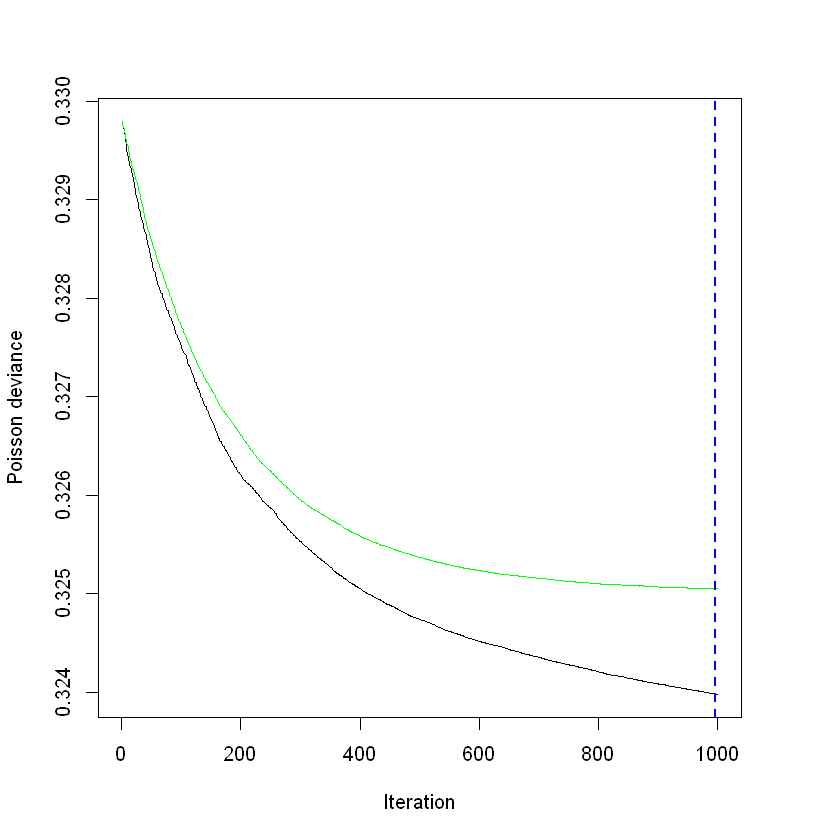

In [19]:
plot(gbmt_performance(m0_gbm), method = "cv")

Let us store the optimal number of iterations.

In [20]:
best_iter = gbmt_performance(m0_gbm, "cv")
best_iter

The best cross-validation iteration was 996.

We can see the variable importance.

,var,rel_inf
,<chr>,<dbl>
DriverAge,DriverAge,43.554801
Density,Density,22.784335
Region,Region,9.077612
Power,Power,7.591321
Brand,Brand,7.387304
CarAge,CarAge,6.459741
Gas,Gas,3.144885


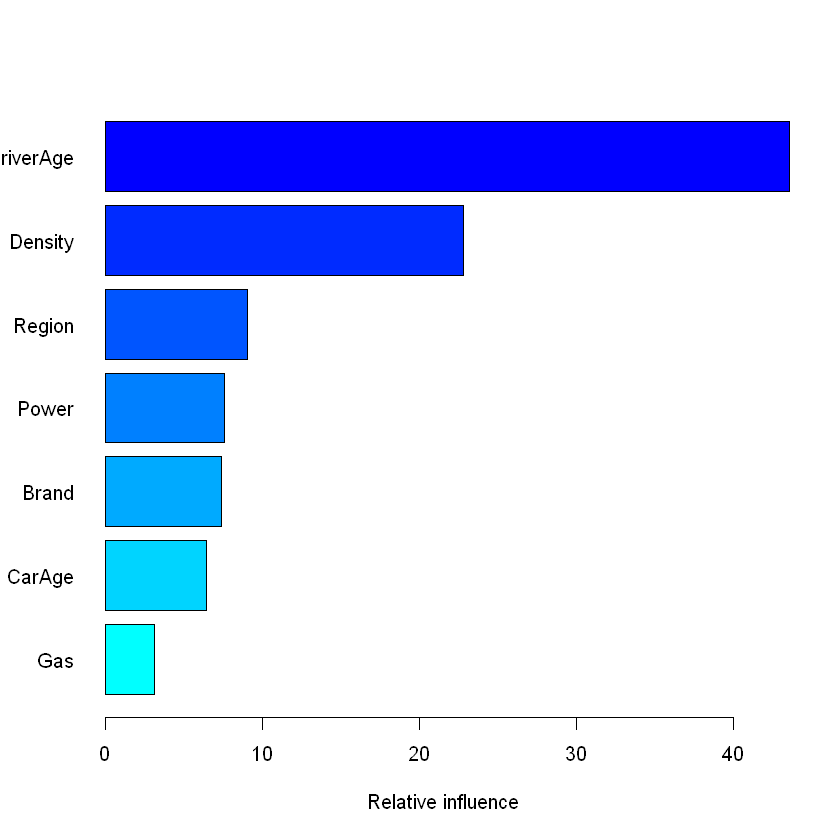

In [21]:
summary(m0_gbm)

We can take a look at the partial dependencies.

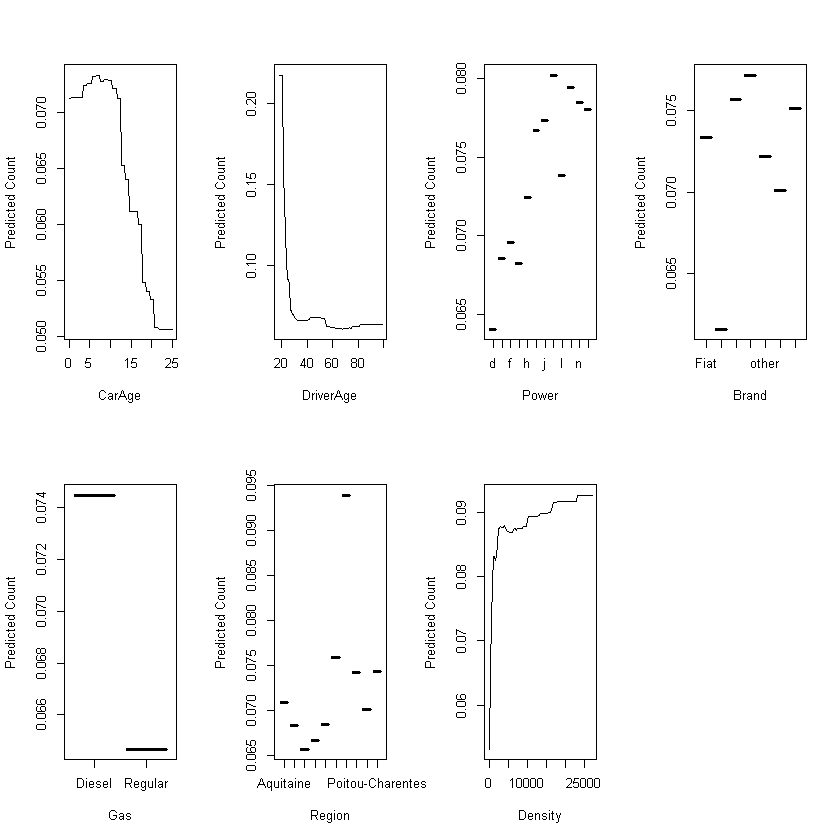

In [22]:
par(mfrow = c(2, 4))
for (i in 1:7) {
    plot(m0_gbm, var_index = i, num_trees = best_iter, type = "response")
}

#### Interactions

Let’s compute Friedman’s H statistic for interaction, for all the possible couple of variable.
Friedman's H statistic allows to identify which variables appear to be in interaction. This is typically a good way to identify interactions for a simpler model, such as a GLM.

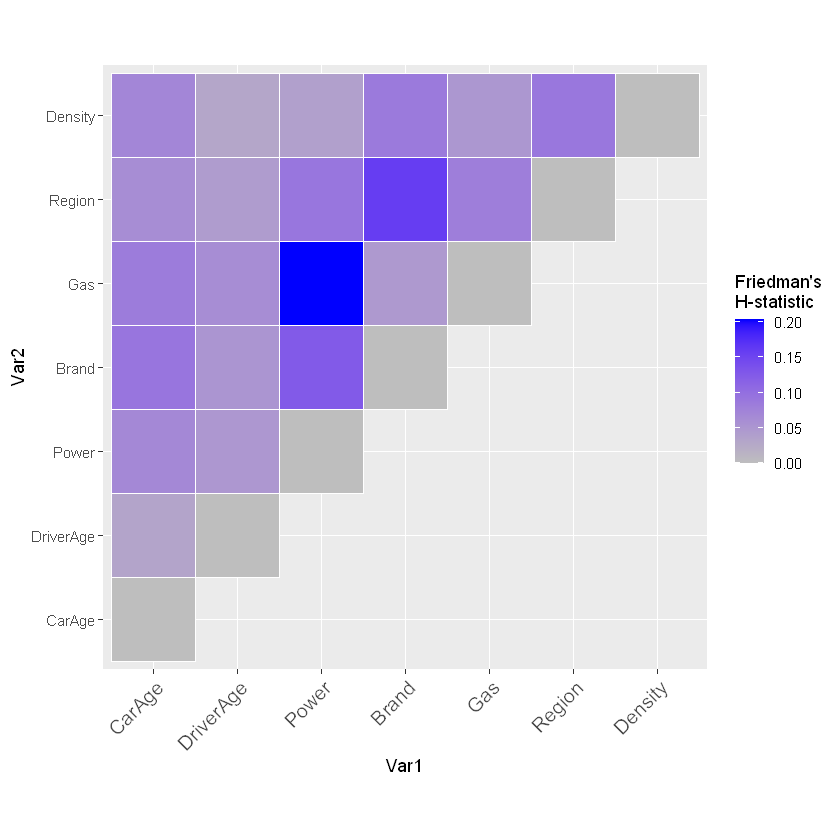

In [23]:
var_names = c("CarAge", "DriverAge", "Power", "Brand", "Gas", "Region", "Density")

res = matrix(NA, 7, 7)
for (i in 1:6) {
    for (j in (i + 1):7) {
        res[i, j] = interact(gbm_fit_obj = m0_gbm, data = training_set, var_indices = c(i,
            j), best_iter)
    }
}
diag(res) = 0
row.names(res) = var_names
colnames(res) = row.names(res)

interact_melt <- melt(res, na.rm = TRUE)

ggplot(data = interact_melt, aes(x = Var1, y = Var2, fill = value)) + geom_tile(color = "white") +
    scale_fill_gradient2(low = "white", mid = "gray", high = "blue", name = "Friedman's\nH-statistic") +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, size = 12, hjust = 1)) +
    coord_fixed()

One by one, let us inspect the partial dependencies of the top ranked couple of variables.

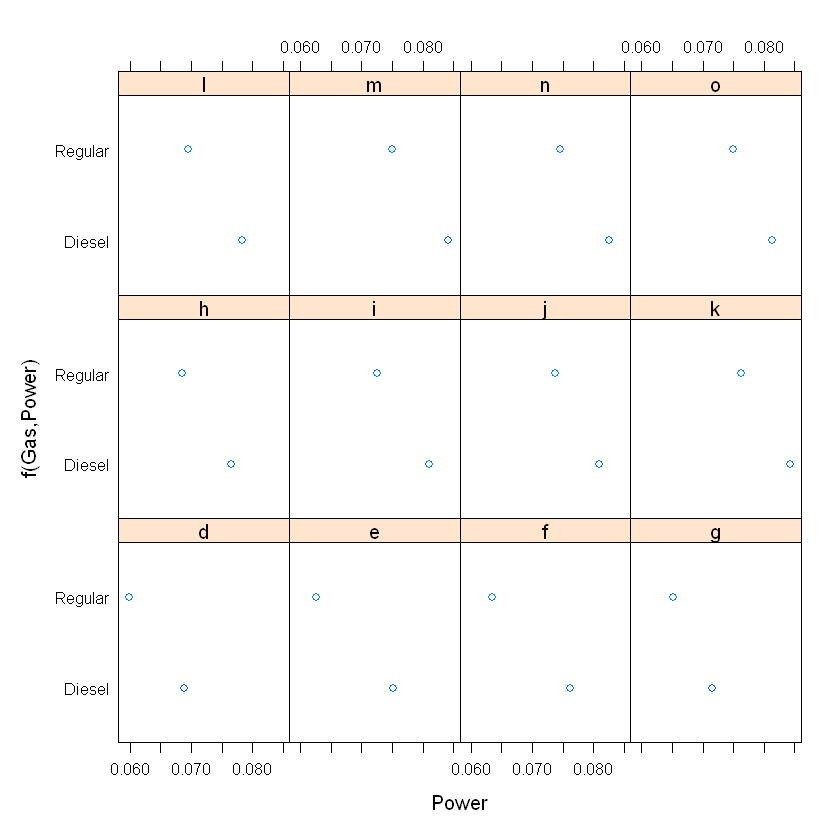

In [24]:
plot(m0_gbm, var_index = c(which(var_names == "Gas"), which(var_names == "Power")),
    num_trees = best_iter, type = "response")  #Power, Gas

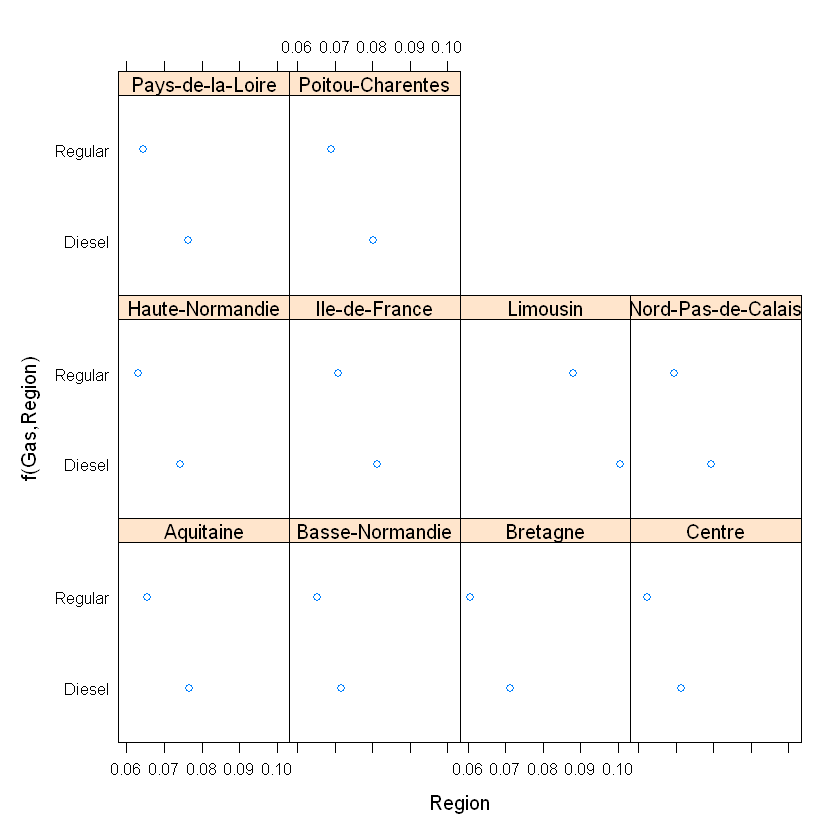

In [25]:
plot(m0_gbm, var_index = c(which(var_names == "Gas"), which(var_names == "Region")),
    num_trees = best_iter, type = "response")  # Gas, Region

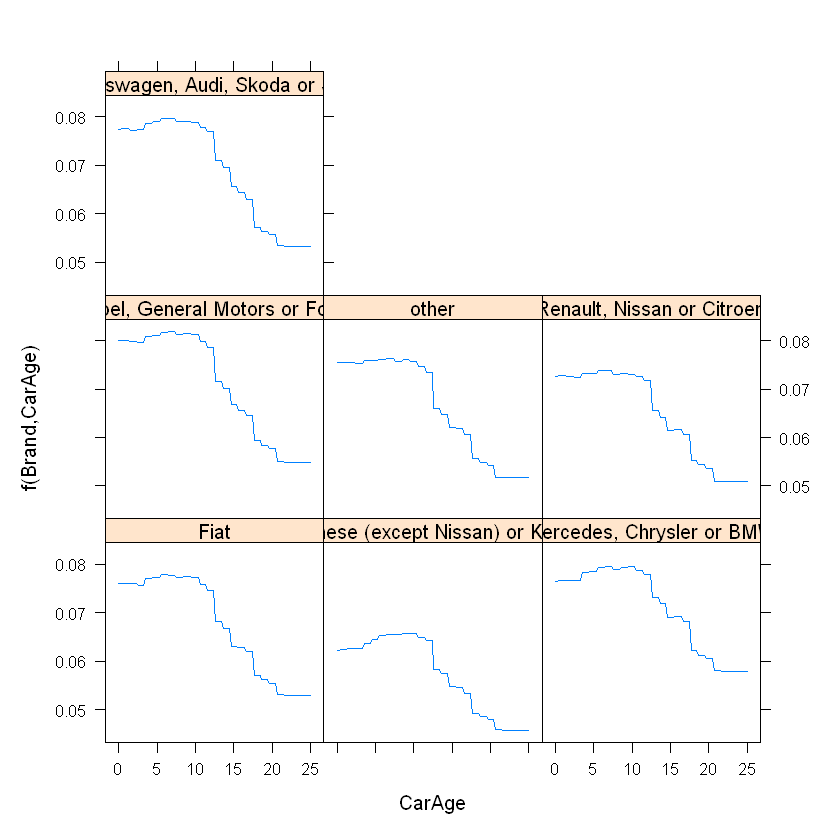

In [26]:
plot(m0_gbm, var_index = c(which(var_names == "Brand"), which(var_names == "CarAge")),
    num_trees = best_iter, type = "response")

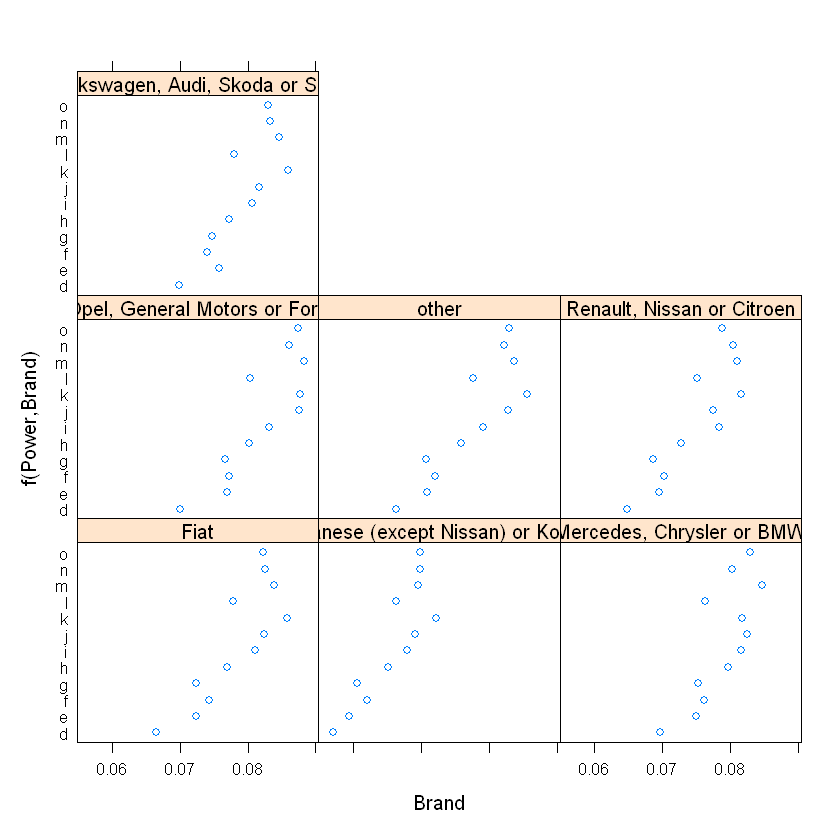

In [27]:
plot(m0_gbm, var_index = c(which(var_names == "Power"), which(var_names == "Brand")),
    num_trees = best_iter, type = "response")  # Gas, Region

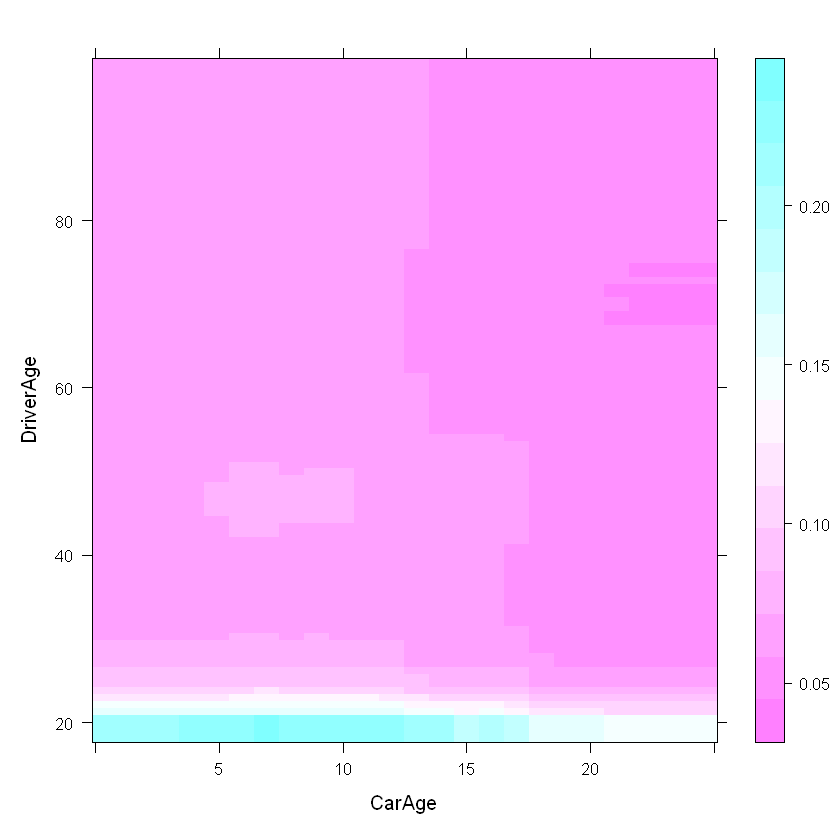

In [28]:
plot(m0_gbm, var_index = c(which(var_names == "CarAge"), which(var_names == "DriverAge")),
    num_trees = best_iter, type = "response")  # Gas, Region

We can check the prediction power of the model on the testing set.

In [29]:
2 * (sum(dpois(x = testing_set$ClaimNb, lambda = testing_set$ClaimNb, log = TRUE)) -
    sum(dpois(x = testing_set$ClaimNb, lambda = predict(m0_gbm, newdata = testing_set,
        n.trees = best_iter, type = "response") * testing_set$Exposure, log = TRUE)))

Warning message in predict.GBMFit(m0_gbm, newdata = testing_set, n.trees = best_iter, :
"predict.GBMFit does not add the offset to the predicted values."


[1] 20413.93

#### Tweaking the model

We would have to tweak the parameters. We should define a grid of parameters and perform cross-validation to choose the optimal parameters. Due to time restriction, we will only show one example, for instance (interaction depth changed from 5 to 10):

In [30]:
set.seed(89)
m1_gbm = gbmt(ClaimNb ~ offset(log(Exposure)) + CarAge + DriverAge + Power + Brand + Gas + Region + Density,
         data = training_set,
         distribution = gbm_dist("Poisson"),
         train_params = training_params(num_trees = 1000,
                                        shrinkage = 0.01, #Default is 0.001
                                        interaction_depth = 10,  #the max number of non-terminal nodes in each tree 
                                        min_num_obs_in_node = 1000,
                                        bag_fraction = 0.5,
                                        num_train = 1*nrow(training_set)),
         is_verbose = FALSE,
         cv_folds = 5,
         par_details = gbmParallel(num_threads = 3)) #Parallel computing
m1_gbm

gbmt(formula = ClaimNb ~ offset(log(Exposure)) + CarAge + DriverAge + 
    Power + Brand + Gas + Region + Density, distribution = gbm_dist("Poisson"), 
    data = training_set, train_params = training_params(num_trees = 1000, 
        shrinkage = 0.01, interaction_depth = 10, min_num_obs_in_node = 1000, 
        bag_fraction = 0.5, num_train = 1 * nrow(training_set)), 
    cv_folds = 5, par_details = gbmParallel(num_threads = 3), 
    is_verbose = FALSE)
A gradient boosted model with Poisson loss function.
 1000 iterations were performed.
The best cross-validation iteration was 999.
There were 7 predictors of which 7 had non-zero influence.

We need to identify the optimal number of boosting iterations...

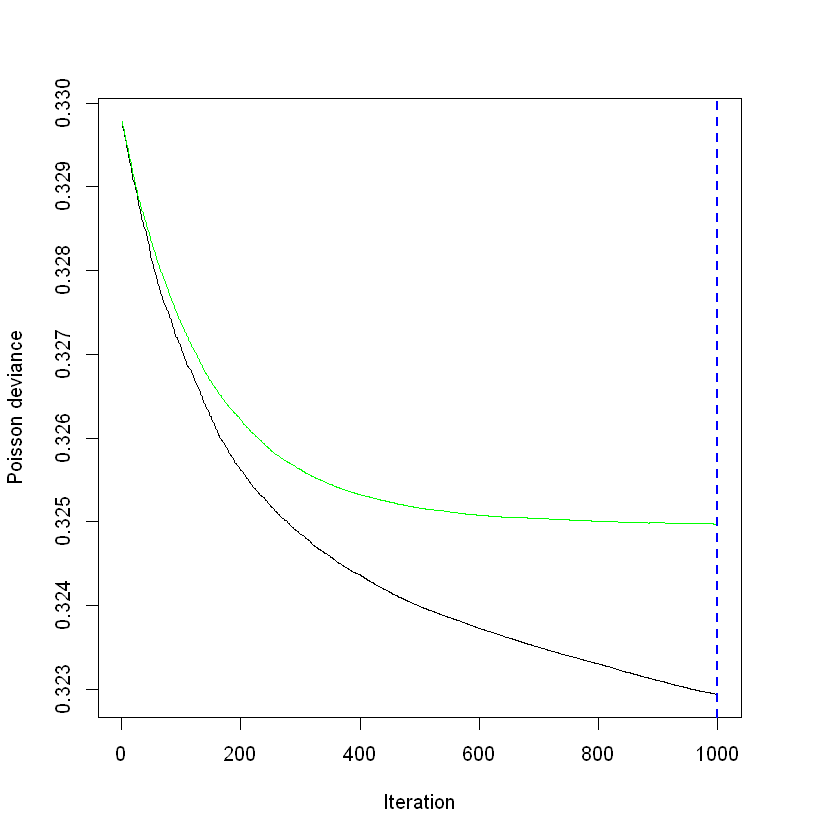

In [31]:
plot(gbmt_performance(m1_gbm, method = "cv"))

Let’s compare both cross-validation errors.

In [32]:
c(min(m0_gbm$cv_error),min(m1_gbm$cv_error))

[1] 0.3250483 0.3249722

The difference seems small… however, if we look at the predictions..

Warning message in predict.GBMFit(m0_gbm, newdata = training_set, n.trees = best_iter, :
"predict.GBMFit does not add the offset to the predicted values."
Warning message in predict.GBMFit(m1_gbm, newdata = training_set, n.trees = best_iter, :
"predict.GBMFit does not add the offset to the predicted values."
Warning message in predict.GBMFit(m0_gbm, newdata = training_set, n.trees = best_iter, :
"predict.GBMFit does not add the offset to the predicted values."
Warning message in predict.GBMFit(m1_gbm, newdata = training_set, n.trees = best_iter, :
"predict.GBMFit does not add the offset to the predicted values."


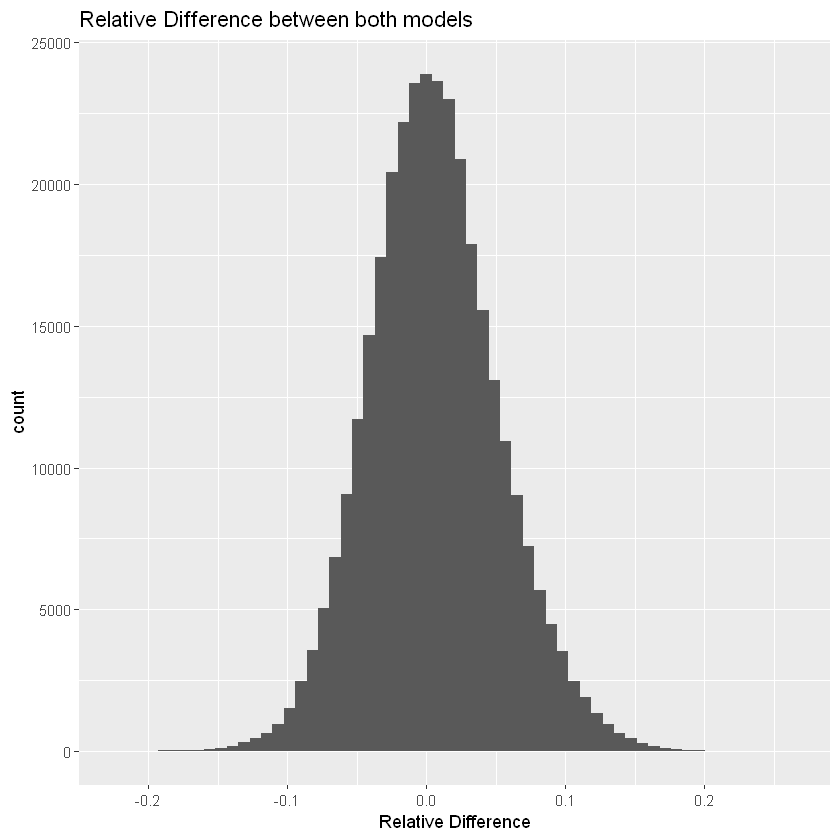

In [33]:
require(ggplot2)
ggplot() + 
  geom_histogram(aes(x=predict(m0_gbm,newdata = training_set,n.trees=best_iter, type="response") / 
                       predict(m1_gbm,newdata = training_set,n.trees=best_iter, type="response") -1),
                 bins=60) + 
  xlab("Relative Difference") + ggtitle("Relative Difference between both models")

In pratice, this means that two actuaries perfoming prediction modelling on the same data are actually very unlikely to obtain for single policies similar predictions, although they might end up with an overall similar loss.

### Intercept of the GBM

It may be required to correct the “intercept” of a gbm. Indeed, let us take at look at the total expected number of claims and compare it to the observed one. Let us do the same comparison with the GAM from above.

In [34]:
pred = data.frame(gbm = predict(m0_gbm,
                                newdata = training_set, 
                                n.trees = best_iter, 
                                type = "response") * training_set$Exposure)

print(paste(c("GBM predicted ", "GBM  obs"),c(sum(pred$gbm), sum(training_set$ClaimNb))))

Warning message in predict.GBMFit(m0_gbm, newdata = training_set, n.trees = best_iter, :
"predict.GBMFit does not add the offset to the predicted values."


[1] "GBM predicted  12914.7334734928" "GBM  obs 12944"                 


GBM tend to underestimate the total number of claims. We could correct the claim frequency with

In [35]:
intercept_correction = sum(training_set$ClaimNb)/sum(pred$gbm)
intercept_correction

[1] 1.002266

Let us do it, and recompute the error on the testing set, first without correction, then with correction.

In [36]:
# Without correction

2*(sum(dpois(x = testing_set$ClaimNb, lambda = testing_set$ClaimNb,log=TRUE))-
  sum(dpois(x = testing_set$ClaimNb, lambda = predict(m0_gbm,newdata = testing_set,n.trees=best_iter, type="response") * testing_set$Exposure,
            log=TRUE)))

Warning message in predict.GBMFit(m0_gbm, newdata = testing_set, n.trees = best_iter, :
"predict.GBMFit does not add the offset to the predicted values."


[1] 20413.93

In [37]:
# With correction

2*(sum(dpois(x = testing_set$ClaimNb, lambda = testing_set$ClaimNb,log=TRUE))-
  sum(dpois(x = testing_set$ClaimNb, lambda = intercept_correction * predict(m0_gbm,newdata = testing_set,n.trees=best_iter, type="response") * testing_set$Exposure,
            log=TRUE)))

Warning message in predict.GBMFit(m0_gbm, newdata = testing_set, n.trees = best_iter, :
"predict.GBMFit does not add the offset to the predicted values."


[1] 20414.05

## Package LightGBM

Other packages than the original R package GBM (or the improved version GBM3) exist now. We can cite XGBoost, LightGBM and Catboost for instance.
In the next section, we will investigate LightGBM (https://lightgbm.readthedocs.io/en/latest/index.html)

Lightgbm has originally been developped by Microsoft, is free and open-source. It is usable in many languages such as Python and R. The original algorithm has been adapted with the final objective to be *light* and *fast* (e.g. https://lightgbm.readthedocs.io/en/latest/Features.html#optimization-in-speed-and-memory-usage)

In [38]:
if (!require('lightgbm')) {install.packages("lightgbm")}
require(lightgbm)

To use LightGBM, we need to create a 'lgb.Dataset' object. Note that the data argument does not accept dataframes. We used data.matrix to convert the dataframe to a matrix. Factors are converted to numbers. We can specify which columns relate to categorical features.

In [39]:
cols = c('CarAge', 'DriverAge', 'Density', 'Power', 'Brand','Gas', 'Region')
lgb_train = lgb.Dataset(data = data.matrix(training_set[cols]), 
                        label = training_set$ClaimNb,
                        categorical_feature = c(4,5,6,7),
                        init_score = log(training_set$Exposure)
                       )

We can call the lightgbm function to estimate our model. The list of parameters we can play with is listed on the website (rather than the R documentation which does not list them all): https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [40]:
set.seed(42)
nrounds = 1000
lgb_m0 = lgb.cv(
      data = lgb_train,
      params = list(
          learning_rate = 0.1,
          max_depth = 10,
          bagging_fraction = 0.5,
          feature_fraction = 1,
          feature_fraction_bynode = 1
      ),
      nrounds = nrounds,
      verbose = 1L,
      eval_freq = 1L,
      objective = "poisson",
      eval = "poisson",
      nfold=5
)

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = 0.1, max_depth = 10, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 262954, number of used features: 7
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=

In [41]:
best.iter = lgb_m0$best_iter
best.iter

[1] 135

In [42]:
best.score = lgb_m0$best_score
best.score

[1] 0.1626468

We can try to tweak the model by changing part of its hyperparameters (again, a gridsearch would be better). Here we are going to search for the optimal max_depth parameter

We could for instance, try to find the optimal max_depth parameter e.g. a range from 2 to 10.

In [44]:
list_hyperparameters = expand.grid(
    learning_rate = 0.1,
    max_depth = seq(2,10,1),
    bagging_fraction = c(0.5, 1),
    feature_fraction = 1,
    feature_fraction_bynode = c(0.5,1),
    score = 0,
    best_iter = 0
)

In [45]:
row = 1
list_hyperparameters[row, 'learning_rate']

[1] 0.1

In [46]:
for (row in seq(nrow(list_hyperparameters))){
    lgb_m1 = lgb.cv(
      data = lgb_train,
      params = list(
          learning_rate = list_hyperparameters[row, 'learning_rate'],
          max_depth = list_hyperparameters[row, 'max_depth'],
          bagging_fraction = list_hyperparameters[row, 'bagging_fraction'],
          feature_fraction = list_hyperparameters[row, 'feature_fraction'],
          feature_fraction_bynode = list_hyperparameters[row, 'feature_fraction_bynode'],
          monotone_constraints = c(0, 0, 0, 1, 0, 0, 0)
      ),
      nrounds = 1000,
      verbose = 0,
      eval_freq = 1L,
      objective = "poisson",
      eval = "poisson",
      nfold=5
    )
    current.iter = lgb_m1$best_iter
    current.score = lgb_m1$best_score
    
    list_hyperparameters[row, 'score'] = current.score
    list_hyperparameters[row, 'best_iter'] = current.iter
}


Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-thr

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-thr

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-thr

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_lea

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_lea

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_lea

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_lea

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_lea

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_lea

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-thr

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-thr

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-thr

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_lea

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_lea

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_lea

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_lea

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_lea

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_lea

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-thr

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-thr

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-thr

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_lea

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_lea

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_lea

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_lea

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_lea

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_lea

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-thr

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-thr

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-thr

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_lea

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_lea

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_lea

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_lea

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_lea

Warning message in lgb.cv(data = lgb_train, params = list(learning_rate = list_hyperparameters[row, :
"lgb.cv: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.cv for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_lea

In [47]:
list_hyperparameters

learning_rate,max_depth,bagging_fraction,feature_fraction,feature_fraction_bynode,score,best_iter
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.1,2,0.5,1,0.5,0.1625395,481
0.1,3,0.5,1,0.5,0.1625227,218
0.1,4,0.5,1,0.5,0.1625269,147
0.1,5,0.5,1,0.5,0.1625590,154
0.1,6,0.5,1,0.5,0.1626252,134
0.1,7,0.5,1,0.5,0.1625789,137
0.1,8,0.5,1,0.5,0.1626101,130
0.1,9,0.5,1,0.5,0.1625855,144
0.1,10,0.5,1,0.5,0.1625549,138


In [48]:
optimal_row = which.min(list_hyperparameters$score)
best_iter = list_hyperparameters[optimal_row,"best_iter"]
learning_rate = list_hyperparameters[optimal_row,"learning_rate"]
max_depth = list_hyperparameters[optimal_row,"max_depth"]
bagging_fraction = list_hyperparameters[optimal_row,"bagging_fraction"]
feature_fraction = list_hyperparameters[optimal_row,"feature_fraction"]
feature_fraction_bynode = list_hyperparameters[optimal_row,"feature_fraction_bynode"]
list_hyperparameters[optimal_row,]

,learning_rate,max_depth,bagging_fraction,feature_fraction,feature_fraction_bynode,score,best_iter
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20,0.1,3,0.5,1,1,0.1624793,210


Re-estimate the whole model with the optimal hyperparameters

In [49]:
lgb_m1_final = lightgbm(
      data = lgb_train,
      params = list(
          learning_rate = learning_rate,
          max_depth = max_depth,
          bagging_fraction = bagging_fraction,
          feature_fraction = feature_fraction,
          feature_fraction_bynode = feature_fraction_bynode,
          monotone_constraints = c(0, 0, 0, 1, 0, 0, 0)
      ),
      nrounds = best_iter,
      verbose = 1L,
      eval_freq = 1L,
      objective = "poisson",
      eval = "poisson"
    )

Warning message in (function (params = list(), data, nrounds = 100L, valids = list(), :
"lgb.train: Found the following passed through '...': objective. These will be used, but in future releases of lightgbm, this warning will become an error. Add these to 'params' instead. See ?lgb.train for documentation on how to call this function."


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 328692, number of used features: 7
[1] "[1]:  train's poisson:0.55799"
[1] "[2]:  train's poisson:0.53572"
[1] "[3]:  train's poisson:0.514608"
[1] "[4]:  train's poisson:0.494599"
[1] "[5]:  train's poisson:0.475637"
[1] "[6]:  train's poisson:0.457672"
[1] "[7]:  train's poisson:0.440654"
[1] "[8]:  train's poisson:0.424537"
[1] "[9]:  train's poisson:0.409276"
[1] "[10]:  train's poisson:0.394829"
[1] "[11]:  trai

In [50]:
pred = predict(lgb_m1_final, data.matrix(testing_set[cols]))

2*(sum(dpois(x = testing_set$ClaimNb, 
             lambda = testing_set$ClaimNb,
             log=TRUE))-
  sum(dpois(x = testing_set$ClaimNb, 
            lambda = pred * testing_set$Exposure, 
            log=TRUE)))

[1] 20419.67

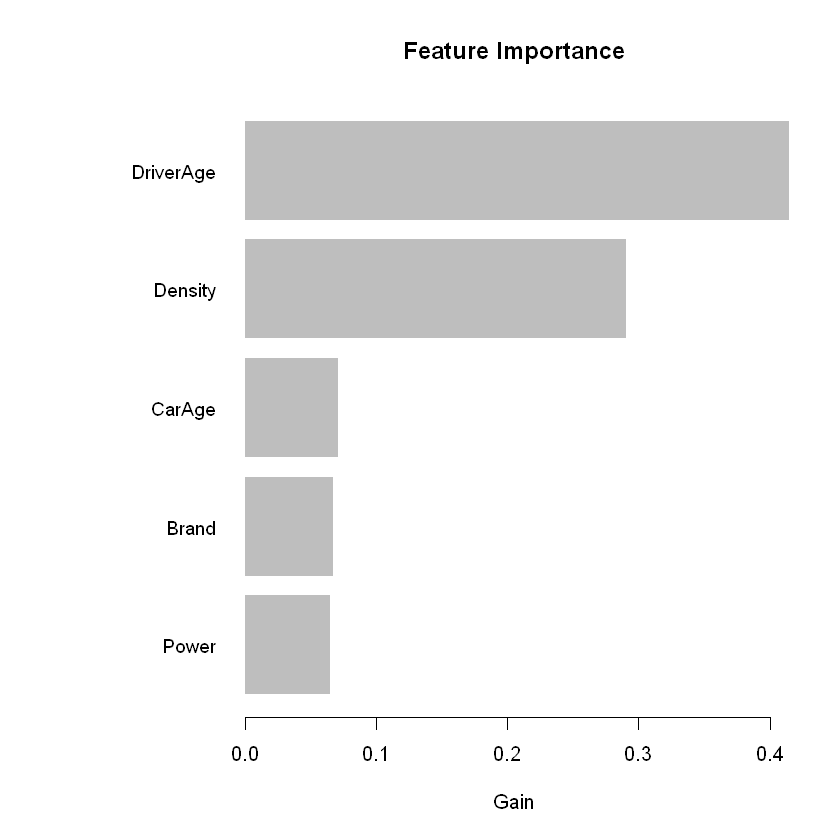

In [51]:
tree_imp = lgb.importance(lgb_m1_final, percentage = TRUE)
lgb.plot.importance(tree_imp, top_n = 5L, measure = "Gain")